## <center> **Analysis of A/B Testing Results**

2 alternatives of the landing page were provided: A and B.

The next products for purchase are available:
* USD 10;
* USD 60;
* USD 100;
* USD 150;
* USD 200.

In one session, only one product is purchased.

The preset metrics are conversion and mean bill.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, ttest_ind, normaltest
from statsmodels.stats.proportion import proportions_ztest

## **1. Exploratory pre-analysis**

**1.1. Read the data provided:**

In [18]:
data = pd.read_csv('ab_usd.csv')
display(data.head())

data.info()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [19]:
#convert date to datetime format
data['date'] = pd.to_datetime(data['date'])

**1.2. Check testing duration and its equality of  for A and B groups:**

In [20]:
data_time_agg = data.groupby('group')['date'].agg(['min','max'])
display(data_time_agg)

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


**1.3. Summarize key values:**

In [21]:
pivot = data.pivot_table(index='group', 
                             values=['user_id','purchase','price'],
                             aggfunc={'user_id':'count',
                                      'purchase':'sum','price':'sum'})
pivot = pivot.rename(columns={'user_id':'count_visits',
                       'purchase':'count_purchases',
                       'price':'sum_price'})
pivot

,sum_price,count_purchases,count_visits
group,,,
A,1436260,17723,147202
B,1554100,17514,147276


**1.4. Uncover users found in both groups and exclude them:**


In [22]:
#Find duplicates
data_a = data[data['group']=='A']
data_b = data[data['group']=='B']
duplicates = pd.merge(data_a, data_b, how = 'inner', on='user_id')
print('Users duplicated in both groups found: ', len(duplicates))
display(duplicates)

Users duplicated in both groups found:  1895


,user_id,date_x,group_x,purchase_x,price_x,date_y,group_y,purchase_y,price_y
0,767017,2021-01-12,A,0,0,2021-01-08,B,0,0
1,733976,2021-01-11,A,0,0,2021-01-05,B,0,0
2,670052,2021-01-07,A,0,0,2021-01-04,B,1,150
3,867227,2021-01-06,A,1,60,2021-01-18,B,0,0
4,808613,2021-01-10,A,0,0,2021-01-05,B,0,0
...,...,...,...,...,...,...,...,...,...
1890,927109,2021-01-04,A,0,0,2021-01-19,B,0,0
1891,928506,2021-01-13,A,0,0,2021-01-21,B,0,0
1892,886135,2021-01-06,A,0,0,2021-01-04,B,0,0
1893,641570,2021-01-09,A,0,0,2021-01-11,B,1,100


In [23]:
#Delete duplicates
upd_data = data[data['user_id'].apply(lambda x: x not in list(duplicates['user_id']))]
print ('Duplicated users are deleted')

Duplicated users are deleted


In [24]:
# Recalculate summary table
pivot = upd_data.pivot_table(index='group', 
                             values=['user_id','purchase','price'],
                             aggfunc={'user_id':'count',
                                      'purchase':'sum','price':'sum'})
pivot = pivot.rename(columns={'user_id':'count_visits',
                       'purchase':'count_purchases',
                       'price':'sum_price'})
print('New summary table after duplicates deletion:')
pivot

New summary table after duplicates deletion:


,sum_price,count_purchases,count_visits
group,,,
A,1417780,17487,145307
B,1533010,17290,145381


*Visit counts for A and B options differ unsignificantly.*

**1.5. New summarizing values are calculated:**
* **Conversion** as a ratio of number of purchases to number of visits, % 
* **Mean bill** as a ratio of total income (sum_price) to number of purchases, USD

In [25]:
pivot['conversion'] = round(pivot['count_purchases']/pivot['count_visits']*100,2)
pivot['mean_bill'] = round(pivot['sum_price']/pivot['count_purchases'])
display(pivot)

,sum_price,count_purchases,count_visits,conversion,mean_bill
group,,,,,
A,1417780,17487,145307,12.03,81.0
B,1533010,17290,145381,11.89,89.0


*Interim conclusions on the summarizing values:
Option А is slightly more effective in terms of conversion, meanwhile option B is more effective in a mean bill.
To verify these estimations, further analysis will be implemented.*

**1.6. Puchase distribution by product**

In [28]:
pivot1 = upd_data[upd_data['price']>0].pivot_table(
    index='group', columns='price',values='purchase',aggfunc='sum')
pivot1

price,10,60,100,150,200
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


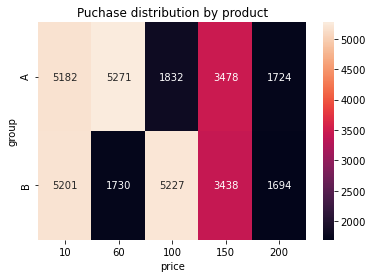

In [31]:
f = sns.heatmap(pivot1, annot=True, fmt=".0f")
f.set_title('Puchase distribution by product');

*Users in group A purchased USD60 products 3 times more often than users in group B. Meanwhile, user in group B purchased USD100 products nearly 3 times more often than users in group A. For other product purchases, no difference between groups was found.* 

## **2. Daily and cumulative metrics**

**2.1. Reorganize data by date and testing group**

In [33]:
grouped = upd_data.groupby(by=['date','group'])['purchase'].agg(['count','sum'])
grouped = grouped.rename(columns={'sum':'purchases','count':'visits'})
grouped1 = upd_data.groupby(by=['date','group'])['price'].agg(['sum'])
grouped1 = grouped1.rename(columns={'sum':'income'})
grouped = grouped.join(grouped1)
grouped['daily_conv'] = round(grouped['purchases']/grouped['visits']*100,2)
grouped['daily_bill'] = round(grouped['income']/grouped['purchases'],2)
grouped.head()

visits  purchases  income  daily_conv  daily_bill
date       group                                                   
2021-01-02 A        2854        359   29410       12.58       81.92
           B        2861        345   29660       12.06       85.97
2021-01-03 A        6596        748   62000       11.34       82.89
           B        6619        754   65960       11.39       87.48
2021-01-04 A        6566        799   64250       12.17       80.41

**2.2. Cumulative values are calculated for:**
* **website visits (cum_visits)**
* **number of purchases (cum_purchases)**
* **sum of purchases (cum_income), USD**

**On this basis, the following cumulative values are also determined:**
* **conversion (cum_conv)**
* **bill (cum_bill)**

In [34]:
grouped['cum_visits'] = grouped.groupby(['group'])['visits'].cumsum()
grouped['cum_purchases'] = grouped.groupby(['group'])['purchases'].cumsum()
grouped['cum_income'] = grouped.groupby(['group'])['income'].cumsum()
grouped['cum_conv'] = round(grouped['cum_purchases']/grouped['cum_visits']*100,2)
grouped['cum_bill'] = round(grouped['cum_income']/grouped['cum_purchases'],2)
grouped

visits  purchases  income  daily_conv  daily_bill  \
date       group                                                      
2021-01-02 A        2854        359   29410       12.58       81.92   
           B        2861        345   29660       12.06       85.97   
2021-01-03 A        6596        748   62000       11.34       82.89   
           B        6619        754   65960       11.39       87.48   
2021-01-04 A        6566        799   64250       12.17       80.41   
           B        6536        764   68030       11.69       89.04   
2021-01-05 A        6433        790   64550       12.28       81.71   
           B        6511        749   63550       11.50       84.85   
2021-01-06 A        6606        764   63410       11.57       83.00   
           B        6751        838   75020       12.41       89.52   
2021-01-07 A        6579        795   67290       12.08       84.64   
           B        6616        767   67170       11.59       87.57   
2021-01-08 A        6687        798   65380       11.93       81.93   
           B        6714        812   71270       12.09       87.77   
2021-01-09 A        6633        794   65610       11.97       82.63   
           B        6628        784   71410       11.83       91.08   
2021-01-10 A        6659        759   58950       11.40       77.67   
           B        6701        846   78080       12.62       92.29   
2021-01-11 A        6699        797   58760       11.90       73.73   
           B        6679        770   66960       11.53       86.96   
2021-01-12 A        6540        795   68460       12.16       86.11   
           B        6635        807   70560       12.16       87.43   
2021-01-13 A        6564        764   63590       11.64       83.23   
           B        6495        720   65910       11.09       91.54   
2021-01-14 A        6543        825   65890       12.61       79.87   
           B        6608        792   68990       11.99       87.11   
2021-01-15 A        6701        806   67570       12.03       83.83   
           B        6563        747   69160       11.38       92.58   
2021-01-16 A        6601        808   66210       12.24       81.94   
           B        6544        786   70560       12.01       89.77   
2021-01-17 A        6619        809   63020       12.22       77.90   
           B        6546        831   75300       12.69       90.61   
2021-01-18 A        6511        812   62850       12.47       77.40   
           B        6603        822   72240       12.45       87.88   
2021-01-19 A        6582        790   63680       12.00       80.61   
           B        6562        772   67820       11.76       87.85   
2021-01-20 A        6533        749   58710       11.46       78.38   
           B        6685        790   69250       11.82       87.66   
2021-01-21 A        6750        851   70300       12.61       82.61   
           B        6555        760   69870       11.59       91.93   
2021-01-22 A        6587        788   63690       11.96       80.82   
           B        6659        787   68660       11.82       87.24   
2021-01-23 A        6698        843   70950       12.59       84.16   
           B        6633        805   68930       12.14       85.63   
2021-01-24 A        3766        444   33250       11.79       74.89   
           B        3677        442   38650       12.02       87.44   

                  cum_visits  cum_purchases  cum_income  cum_conv  cum_bill  
date       group                                                             
2021-01-02 A            2854            359       29410     12.58     81.92  
           B            2861            345       29660     12.06     85.97  
2021-01-03 A            9450           1107       91410     11.71     82.57  
           B            9480           1099       95620     11.59     87.01  
2021-01-04 A           16016           1906      155660     11.90     81.67  
           B           16016           1863      163650     11.

**2.3. Cumulative plots of conversion and mean bill**

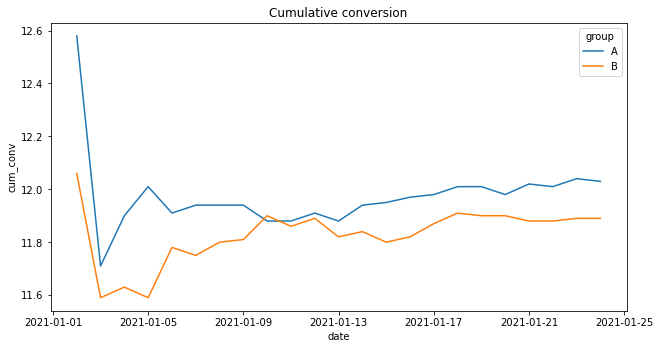

In [37]:
fig = plt.figure(figsize = (8,4))
ax = fig.add_axes([1,1,1,1])
sns.lineplot(data = grouped, x = 'date', y='cum_conv', hue = 'group', ax=ax)
ax.set_title('Cumulative conversion');

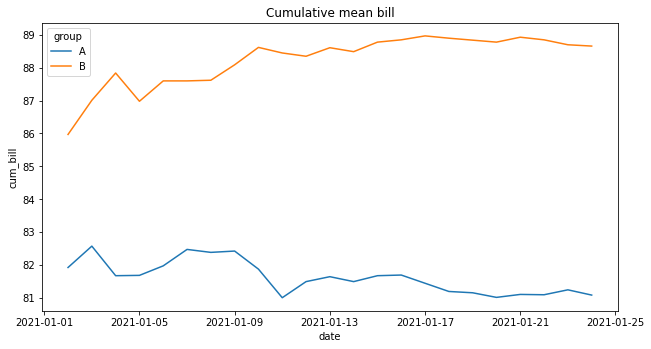

In [38]:
fig = plt.figure(figsize = (8,4))
ax = fig.add_axes([1,1,1,1])
sns.lineplot(data = grouped, x = 'date', y='cum_bill', hue = 'group', ax=ax)
ax.set_title('Cumulative mean bill');

*Interim conclusions on the summarizing values:
Both cumulative metrics were stabilized, therefore the A/B test may be considered finished.
Cumulative conversion is slightly greater in group A (ca.12.0%) than in group B (ca.11.9%)
A cumulative mean bill is greater in group B (ca.USD89) than in group A (ca.USD 81).
To verify these estimations, further analysis of statistical significance will be implemented.*

## **3. Statistical significance of difference in metrics between groups**

### **3.1. Conversion**

**a)  Test a hypothesis for conversion difference**

* $H_0$: Conversions in A and B groups are equal; 
* $H_1$: Conversion in group A is greater than in group B;

Set significance level $\alpha$=0.05. 

Conversion is a kind of proportion (purchases/visits), and it may be interpreted as a success probability in Bernoulli distribution. Therefore, we use a **Z-test for proportions**.

In [45]:
alpha = 0.05
H0 = 'Null Hypothesis: Conversions in A and B groups are equal'
H1 = 'Conversion in group A is greater than in group B'

_, p_value = proportions_ztest(count = pivot['count_purchases'], 
                               nobs = pivot['count_visits'],
                               alternative = 'larger')
if p_value > alpha:
    print(f'p-value={round(p_value,2)} > alpha={alpha}, therefore we cannot reject the {H0}.' )
else:
    print(f'p-value={roung(p_value,2)} < alpha={alpha}, therefore we reject the Null Hypothesis and assume that {H1}.' )      

p-value=0.12 > alpha=0.05, therefore we cannot reject the Null Hypothesis: Conversions in A and B groups are equal.


**b) Confidence intervals (CI) for conversions and their difference**

Set 95% confidence, i.e. significance level $\alpha$=0.05

In [46]:
from scipy.stats import norm
z_crit = -norm.ppf(alpha/2)

#sampling proportion values
Xpa = pivot.loc['A']['count_purchases'] / pivot.loc['A']['count_visits']
Xpb = pivot.loc['B']['count_purchases'] / pivot.loc['B']['count_visits']

#sample sizes
n_a = pivot.loc['A']['count_visits']
n_b = pivot.loc['B']['count_visits']

#under-the-root intemediary values
eps_a = Xpa * (1-Xpa) / n_a
eps_b = Xpb * (1-Xpb) / n_b

lower_a = Xpa - z_crit * (eps_a)**0.5
upper_a = Xpa + z_crit * (eps_a)**0.5
#provide CI in percents and round values:
CI_a = [round(lower_a*100, 2), round(upper_a*100, 2) ]

lower_b = Xpb - z_crit * (eps_b)**0.5 
upper_b = Xpb + z_crit * (eps_b)**0.5 
CI_b = [round(lower_b*100, 2), round(upper_b*100, 2) ]

error_ab = z_crit * ((eps_a) + (eps_b))**0.5
lower_ab = (Xpb - Xpa) - error_ab
upper_ab = (Xpb - Xpa) + error_ab
CI_ab = [round(lower_ab*100, 2), round(upper_ab*100, 2) ]

print (f'95% CI for conversion in A: {CI_a}, centered at Xpa={round(Xpa*100,2)}')
print (f'95% CI for conversion in B: {CI_b}, centered at Xpb={round(Xpb*100,2)}')
print (f'95% CI for difference in B - A conversions: {CI_ab}')

95% CI for conversion in A: [11.87, 12.2], centered at Xpa=12.03
95% CI for conversion in B: [11.73, 12.06], centered at Xpb=11.89
95% CI for difference in B - A conversions: [-0.38, 0.09]


*CIs for A and B groups are intersected. The CI for the difference in B-A conversions has bounds of different signs, therefore one can't determine which conversion is greater with 95% confidence, and we assume there's no difference between conversions for groups A and B.*

### **3.2. Mean bill**

**a) Testing daily mean bill distributions for normality**

Set significance level $\alpha$ = 0.05

In [51]:
bills_a = grouped.xs('A', level = "group")['daily_bill']
bills_b = grouped.xs('B', level = "group")['daily_bill']

In [54]:
H0 = 'the distribution is normal'
H1 = 'the distribution is different from normal'
_, p_a = normaltest(bills_a)
_, p_b = normaltest(bills_b)

print('Group A:')
if p_a > alpha:
    print(f'p-value={round(p_a,2)} > alpha={alpha}, therefore we cannot reject H0: {H0}.' )
else:
    print(f'p-value={round(p_a,2)} < alpha={alpha}, therefore we reject H0 and assume that {H1}.' )  
    
print('Group В:')
if p_b > alpha:
    print(f'p-value={round(p_b,2)} > alpha={alpha}, therefore we cannot reject H0: {H0}.' )
else:
    print(f'p-value={round(p_b,2)} < alpha={alpha}, therefore we reject H0 and assume that {H1}.' )    

if ((p_a > alpha) & (p_b > alpha)):
    print('Both distributions are normal, therefore we further are going to use t-test for their comparison.')
else:
    print('We have to use a non-parametric test.')
    
#print(p)

Group A:
p-value=0.25 > alpha=0.05, therefore we cannot reject H0: the distribution is normal.
Group В:
p-value=0.42 > alpha=0.05, therefore we cannot reject H0: the distribution is normal.
Both distributions are normal, therefore we further are going to use t-test for their comparison.


**b) T-test for comparison of mean daily checks**

Set hypotheses:
* $H_0$: Daily mean bills in groups A and B are equal; 
* $H_1$: Daily mean bills in group A is less than in group B;

Set significance level $\alpha$ = 0.05. 

In [56]:
H0 = 'daily mean bills in groups A and B are equal'
H1 = 'daily mean bills in group A is less than in group B'

results = ttest_ind(a = bills_a,
                    b = bills_b,
                    alternative = 'less')

print('p-value = ', results.pvalue)
if results.pvalue > alpha:
    print(f'p-value={round(results.pvalue,2)} > alpha={alpha}, therefore we cannot reject H0: {H0}.' )
else:
    print(f'p-value={round(results.pvalue,2)} < alpha={alpha}, therefore we reject H0 and assume that {H1}.' )    


p-value =  1.1152436810825823e-12
p-value=0.0 < alpha=0.05, therefore we reject H0 and assume that daily mean bills in group A is less than in group B.


**c) CI for mean daily bills**

Set 95% confidence, i.e. significance level $\alpha$=0.05.

The sampling size (number of days) is less than 30, therefore $t_{crit}$ rather than $z_{crit}$ is used in calculations.

In [59]:
def t_CI(data, alpha=0.05):
    
    import numpy as np
    from scipy.stats import t
    
    n = len(data)
    k = n - 1 #degrees of freedom
    t_crit = -t.ppf(alpha/2, k)    
    
    data_mean = data.mean()    
    error = t_crit * data.std() / n**0.5

    lower = data_mean - error
    upper = data_mean + error
    CI = np.round([lower, upper],2)

    print (f'{(1-alpha)*100}% CI: {CI}, centered at {round(data_mean,2)}')


print('Mean daily bill in group A, USD:')
t_CI(data = bills_a)

print('Mean daily bill in group B, USD:')
t_CI(data = bills_b)


Mean daily bill in group A, USD:
95.0% CI: [79.63 82.31], centered at 80.97
Mean daily bill in group B, USD:
95.0% CI: [87.62 89.52], centered at 88.57


*There are no intersections of CIs for groups A and B. Therefore, the mean bill in group B is significantly greater than in group A.*